# CEIA - NLP Desafío N°3
## Martín Andújar


# Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Librerias y funciones

In [1]:
import random
import io
import pickle

from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Bidirectional

import urllib.request # descargar de textos.info
import bs4 as bs # Para leer y parsear el texto en HTML de wikipedia

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [2]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,model_name,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [3]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [4]:
def model_response(human_text,model):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

In [5]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [6]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model,num_beams,num_words,input,max_length,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input,max_length)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

## Datos
Utilizaremos como dataset **La Vida de Lazarillo de Tormes y de sus Fortunas y Adversidades**, una novela picaresca anónima del siglo XVI que narra la vida de Lázaro, un joven de origen humilde que sirve a distintos amos mientras intenta sobrevivir en una sociedad marcada por la pobreza, la picardía y la hipocresía. A través de sus experiencias, el relato ofrece una crítica social irónica y realista de la España de la época.

In [7]:
raw_html = urllib.request.urlopen('https://www.textos.info/anonimo/la-vida-del-lazarillo-de-tormes-y-de-sus-fortunas-y-adversidades/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

# en article text se encuentra el texto de todo el libro
article_text[:1000]
#article_text.splitlines()[:100]

' yo por bien tengo que cosas\r\ntan señaladas, y por ventura nunca oídas ni vistas,\r\nvengan a noticia de muchos y no se entierren en la sepultura del\r\nolvido, pues podría ser que alguno que las lea halle algo\r\nque le agrade, y a los que no ahondaren tanto los deleite; y a\r\neste propósito dice plinio que no hay libro, por malo que\r\nsea, que no tenga alguna cosa buena; mayormente que los gustos no\r\nson todos unos, mas lo que uno no come, otro se pierde por ello.\r\ny así vemos cosas tenidas en poco de algunos, que de otros\r\nno lo son. y esto, para ninguna cosa se debría romper ni\r\nechar a mal, si muy detestable no fuese, sino que a todos se\r\ncomunicase, mayormente siendo sin perjuicio y pudiendo sacar\r\ndella algún fruto; porque si así no fuese, muy\r\npocos escribirían para uno solo, pues no se hace sin\r\ntrabajo, y quieren, ya que lo pasan, ser recompensados, no con\r\ndineros, mas con que vean y lean sus obras, y si hay de\r\nqué, se las alaben; y a este propósito

### Elegir el tamaño del contexto

In [8]:
# seleccionamos el tamaño de contexto
max_context_size = 200

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

# la longitud de vocabulario de caracteres es:
len(chars_vocab)

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [9]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:10]

[54, 43, 20, 54, 36, 20, 30, 54, 49, 21]

### Organizando y estructurando el dataset

In [10]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1

num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

vocab_size = len(chars_vocab)
vocab_size

60

## Definición de Modelos y Entrenamiento

En esta sección se entrenarán los modelos propuestos: SimpleRNN, LSTM y GRU. Se utilizarán los datos de entrenamiento y validación preparados en las celdas previas. El entrenamiento se realizará durante 20 épocas o hasta que la métrica Perplejidad deje de mejorar en los datos de validación (utilizando Early Stopping)

### Modelo 1 - Simple RNN

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [11]:
model_simpleRNN = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_simpleRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 60)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        52,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 60)       │        12,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,260 (251.02 KB)

 Trainable params: 64,260 (251.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [12]:
history_ppl_sRNN= []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_sRNN,model_name='model_simpleRNN')], batch_size=256)

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.7044
 mean perplexity: 8.966357231140137 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - loss: 2.7036
Epoch 2/20
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0970
 mean perplexity: 8.460779190063477 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 2.0968
Epoch 3/20
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9861
 mean perplexity: 7.9151482582092285 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 1.9860
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9000
 mean perplexity: 7.670608043670654 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.8999
Epoch 5/20
378/379 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8365
 mean perplexity: 7.649097442626953 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.8364
Epoch 6/20
377/379 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7881
 mean perplexity: 7.673932

In [13]:
# Guarda el modelo completo
model_simpleRNN.save("model_simpleRNN.keras")
files.download("model_simpleRNN.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

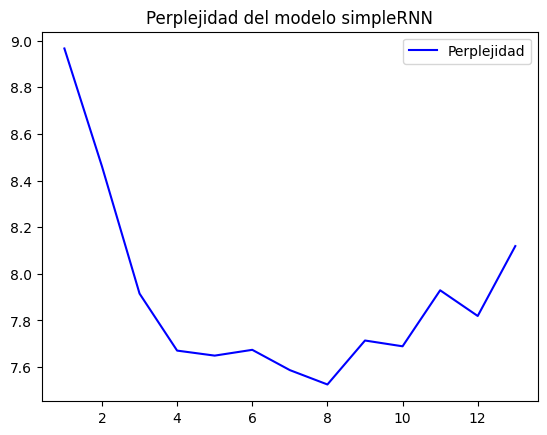

In [14]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_sRNN) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_sRNN, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo simpleRNN')
plt.show()

### Modelo 2 - LSTM

In [15]:
# Modelo basado en LSTM
model_LSTM = Sequential([
    Input(shape=(None, 1)),  # Define la entrada aquí
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 60)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        64,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 60)       │         6,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,460 (275.23 KB)

 Trainable params: 70,460 (275.23 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [16]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM,model_name='model_LSTM')], batch_size=256)

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 3.0705
 mean perplexity: 12.005101203918457 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 221s 554ms/step - loss: 3.0699
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 2.3924
 mean perplexity: 9.784810066223145 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 206s 543ms/step - loss: 2.3922
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 2.2204
 mean perplexity: 9.310562133789062 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 205s 541ms/step - loss: 2.2203
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 2.1506
 mean perplexity: 9.068647384643555 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 205s 540ms/step - loss: 2.1505
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 2.1036
 mean perplexity: 8.978134155273438 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 205s 542ms/step - loss: 2.1036
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 2.0658
 mean perp

In [17]:
# Guarda el modelo completo
#model_simpleRNN.save("model_simpleRNN.keras")
#files.download("model_LSTM.keras")

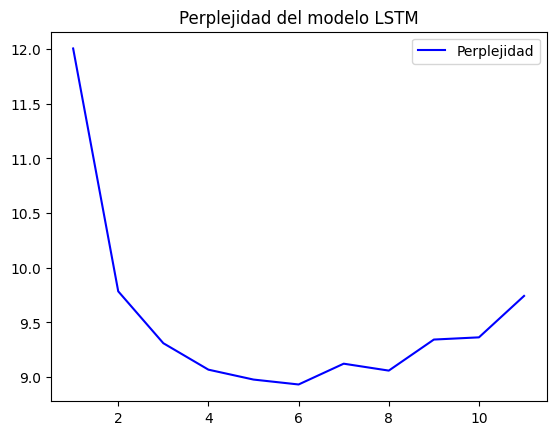

In [18]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_LSTM) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_LSTM, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo LSTM')
plt.show()

### Modelo 3 - GRU

In [19]:
#Modelo GRU
model_GRU = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 60)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 100)      │        48,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 60)       │         6,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,660 (213.52 KB)

 Trainable params: 54,660 (213.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [20]:
history_ppl_GRU = []
hist_GRU = model_GRU.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU,model_name='model_GRU')], batch_size=256)

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 2.9407
 mean perplexity: 9.33981704711914 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 205s 520ms/step - loss: 2.9398
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 2.1622
 mean perplexity: 8.350430488586426 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 191s 505ms/step - loss: 2.1621
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 2.0158
 mean perplexity: 7.949808597564697 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 191s 504ms/step - loss: 2.0158
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 1.9269
 mean perplexity: 7.719709396362305 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 193s 510ms/step - loss: 1.9269
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 1.8629
 mean perplexity: 7.653658866882324 

Saved new model!
379/379 ━━━━━━━━━━━━━━━━━━━━ 192s 506ms/step - loss: 1.8629
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 1.8138
 mean perple

In [21]:
# Guarda el modelo completo
#model_GRU.save("model_GRU.keras")
#files.download("model_GRU.keras")

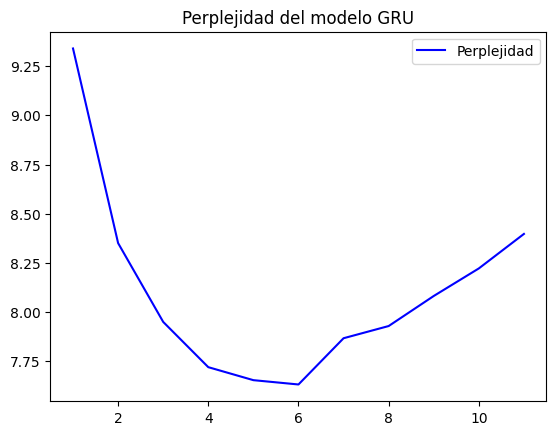

In [22]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_GRU) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_GRU, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo GRU')
plt.show()

## Resultados Entrenamiento

Se puede observar que SimpleRNN llegó a mejores resultados en cuanto a perplejidad.

Sin embargo, tanto para LSTM como para GRU se podría llegar a mejores resultados aún agregando épocas o ajustando hiperparámetros.

Debido a los costos de entrenamiento (complejidad computacional) se limitaron estas pruebas.


## Predicción del próximo caracter

In [23]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_GRU= keras.models.load_model('model_GRU.keras')

Haremos la predicción del próximo caracter sobre la siguiente oracion:

**"lazaro caminaba con su amo, pensando en "**

In [24]:
text="lazaro caminaba con su amo, pensando en "

In [25]:
print(f'Modelo Simple RNN: {model_response(text,model_simpleRNN)}')
print(f'Modelo LSTM: {model_response(text,model_LSTM)}')
print(f'Modelo GRU: {model_response(text,model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Modelo Simple RNN: lazaro caminaba con su amo, pensando en e
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Modelo LSTM: lazaro caminaba con su amo, pensando en a
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Modelo GRU: lazaro caminaba con su amo, pensando en e


In [26]:
text="lazaro caminaba con su amo, pensando en remotamente si le sería posible sali"

In [27]:
print(f'Modelo Simple RNN: {model_response(text,model_simpleRNN)}')
print(f'Modelo LSTM: {model_response(text,model_LSTM)}')
print(f'Modelo GRU: {model_response(text,model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Modelo Simple RNN: lazaro caminaba con su amo, pensando en remotamente si le sería posible salie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Modelo LSTM: lazaro caminaba con su amo, pensando en remotamente si le sería posible salie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Modelo GRU: lazaro caminaba con su amo, pensando en remotamente si le sería posible salir


## Generación de secuencias

In [28]:
input_text='lazaro de tormes '

In [29]:
print(f'Modelo Simple RNN: {generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=50)}')
print(f'Modelo LSTM: {generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=50)}')
print(f'Modelo GRU: {generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=50)}')

Modelo Simple RNN: lazaro de tormes de la casa y santino que el alguacil desta manera 
Modelo LSTM: lazaro de tormes de la me haba de la me haba de la me haba de la me
Modelo GRU: lazaro de tormes de la calle a la calle a la calle a la calle a la 


###  Beam search y muestreo aleatorio

La temperatura (temp) es un parámetro clave en el beam search estocástico (sto) que controla la aleatoriedad en la selección de tokens.

Efecto de la Temperatura

temp → 0: Se vuelve más determinista, eligiendo casi siempre el token con mayor probabilidad.

Si temp = 0, el softmax generaría una distribución en la que el token más probable tiene peso 1, lo que equivale a una selección completamente determinista.

temp = 1: Mantiene la distribución de probabilidades original sin alteraciones.

temp > 1: Hace que la distribución sea más plana, aumentando la exploración (incluso tokens con menor probabilidad pueden ser elegidos).

temp → ∞: Se convierte en una selección casi uniforme, donde todos los tokens tienen una probabilidad similar de ser elegidos.

#### Temperatura = 0.01

In [30]:
# predicción con beam search
print ('Temperatura=0.01')

Temperatura=0.01


In [31]:
salidas = beam_search(model_simpleRNN,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

Modelo Simple RNN: lazaro de tormes de la casa y santa de la casa y santa de la casa y


In [32]:
salidas = beam_search(model_LSTM,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

Modelo LSTM: lazaro de tormes de la me haba de la me haba de la me haba de la ma


In [33]:
salidas = beam_search(model_GRU,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

Modelo GRU: lazaro de tormes de la calle a la calle a la calle a la calle a la 


#### Temperatura = 0.5

In [34]:
# predicción con beam search
print ('Temperatura=0.5')

Temperatura=0.5


In [35]:
salidas = beam_search(model_simpleRNN,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

Modelo Simple RNN: lazaro de tormes de la casa, y como sin había de la casa, y como si


In [36]:
salidas = beam_search(model_LSTM,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

Modelo LSTM: lazaro de tormes de la las que de había de había de había de la hab


In [37]:
salidas = beam_search(model_GRU,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

Modelo GRU: lazaro de tormes de la cual de la cual de la calle y como de la cua


#### Temperatura = 1

In [38]:
# predicción con beam search
print ('Temperatura=1')

Temperatura=1


In [39]:
salidas = beam_search(model_simpleRNN,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

Modelo Simple RNN: lazaro de tormes lo que el alguacil dije yo-, porque en las manos y


In [40]:
salidas = beam_search(model_LSTM,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

Modelo LSTM: lazaro de tormes de par el la la con el puesto y que en entado de a


In [41]:
salidas = beam_search(model_GRU,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

Modelo GRU: lazaro de tormes de la cual, y con el como y como con todo de la ca


#### Temperatura = 1.5

In [42]:
# predicción con beam search
print ('Temperatura=1.5')

Temperatura=1.5


In [43]:
salidas = beam_search(model_simpleRNN,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1.5,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

Modelo Simple RNN: lazaro de tormes y de mi amo de la casa y
después que el diempo su


In [44]:
salidas = beam_search(model_LSTM,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1.5,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

Modelo LSTM: lazaro de tormes que come de la mentanto, muver este cono que el fr


In [45]:
salidas = beam_search(model_GRU,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1.5,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

Modelo GRU: lazaro de tormes de la
puesto en la como me
pocos de mi cabo de e


#### Determinista

In [46]:
# predicción con beam search
print ('Determinista')

Determinista


In [47]:
salidas = beam_search(model_simpleRNN,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,mode='det')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

Modelo Simple RNN: lazaro de tormes de manera que no había manera que no había manera 


In [48]:
salidas = beam_search(model_LSTM,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1,mode='det')
print(f'Modelo LSTM: {decode(salidas[0])}')

Modelo LSTM: lazaro de tormes que esto de había de había de había de había, y co


In [49]:
salidas = beam_search(model_GRU,num_beams=10,num_words=50,input=input_text,max_length=max_context_size,temp=1,mode='det')
print(f'Modelo GRU: {decode(salidas[0])}')

Modelo GRU: lazaro de tormes que no había que no había que no había que no habí


## Conclusiones Generales

En este trabajo se entrenaron y compararon tres modelos basados en redes recurrentes (SimpleRNN, LSTM y GRU) para generar texto en español. Para evaluar su desempeño se utilizó la perplejidad, que mide qué tan bien cada modelo puede predecir el siguiente carácter del texto.

Los resultados mostraron que SimpleRNN obtuvo la mejor perplejidad en las condiciones de entrenamiento usadas. LSTM y GRU tuvieron un rendimiento aceptable, pero es probable que puedan mejorar si se ajustan mejor los hiperparámetros o se entrenan durante más tiempo, algo que no se hizo por las limitaciones de cómputo en Colab.

En general, los tres modelos lograron aprender patrones básicos del texto, como la formación de palabras y la separación entre ellas. Aun así, en algunos casos aparecieron secuencias de caracteres que no pertenecían al texto original, lo que indica que todavía hay margen de mejora. También se observó que las configuraciones con Beam Search estocástico y temperaturas altas fueron las más inestables, algo esperable al trabajar con tokenización a nivel de caracteres.